In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import math
import matplotlib.pyplot as plt

#####################################
# GBM-Based Synthetic Dataset
#####################################
class GBMDataset(Dataset):
    def __init__(self, length=5000, seq_len=50, S0=100, mu=0.05, sigma=0.2, dt=1/252):
        self.seq_len = seq_len
        total_length = length + seq_len
        # Generate GBM prices
        prices = torch.zeros(total_length)
        prices[0] = S0
        for t in range(1, total_length):
            Z = torch.randn(1)
            prices[t] = prices[t-1] * torch.exp((mu - 0.5 * sigma**2)*dt + sigma*math.sqrt(dt)*Z)
        self.data = prices
        
    def __len__(self):
        return len(self.data) - self.seq_len
    
    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_len]
        y = self.data[idx+self.seq_len]
        # x: (seq_len,), y: scalar
        return x.unsqueeze(-1), y.unsqueeze(-1)  # (seq_len,1), (1,)

#####################################
# LSTM Model
#####################################
class TwoLayerLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=2, output_size=1):
        super(TwoLayerLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        last_out = out[:, -1, :]
        preds = self.fc(last_out)
        return preds

#####################################
# Sharpe Ratio Function
#####################################
def sharpe_ratio(returns):
    mean_ret = torch.mean(returns)
    std_ret = torch.std(returns)
    if std_ret == 0:
        return torch.tensor(0.0, device=returns.device)
    return mean_ret / std_ret

#####################################
# Training Parameters
#####################################
seq_len = 50
batch_size = 32
epochs = 300   # example number of epochs
learning_rate = 0.001
lambda_sr = 0.1
lambda_returns = 0.5
lambda_dir = 0.01  # Weight for directionality loss, adjust as needed

#####################################
# Prepare Data
#####################################
train_dataset = GBMDataset(length=5000, seq_len=seq_len, S0=100, mu=0.05, sigma=0.2, dt=1/252)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = GBMDataset(length=1000, seq_len=seq_len, S0=110, mu=0.05, sigma=0.2, dt=1/252)

#####################################
# Predict and Plot Function
#####################################
def predict_and_plot(model, test_dataset, N=200):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for i in range(min(len(test_dataset), N)):
            features, target = test_dataset[i]
            features = features.unsqueeze(0).to(device)  # move features to the same device
            pred = model(features)
            predictions.append(pred.item())
            actuals.append(target.item())
    
    plt.figure(figsize=(10,5))
    plt.plot(range(len(actuals)), actuals, label='Actual', color='blue')
    plt.plot(range(len(predictions)), predictions, label='Predicted', color='red', linestyle='--')
    plt.title('Actual vs Predicted Prices')
    plt.xlabel('Time Step')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()
    model.train()

#####################################
# Training Loop (Sharpe Ratio on Returns)
#####################################

# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming you have already defined your model
model = TwoLayerLSTM(input_size=1, hidden_size=32, num_layers=2, output_size=1).to(device)

# Also, ensure your loss function and optimizer remain the same
criterion_mse = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch [1/300] - Combined Loss: 0.5097, MSE: 0.4302, SR: 0.2054, Dir Loss: 0.4998
Epoch [2/300] - Combined Loss: 0.5170, MSE: 0.4387, SR: 0.1925, Dir Loss: 0.4875
Epoch [3/300] - Combined Loss: 0.4975, MSE: 0.4206, SR: 0.2084, Dir Loss: 0.4879
Epoch [4/300] - Combined Loss: 0.4960, MSE: 0.4207, SR: 0.2143, Dir Loss: 0.4833
Epoch [5/300] - Combined Loss: 0.5445, MSE: 0.4649, SR: 0.1862, Dir Loss: 0.4902
Epoch [6/300] - Combined Loss: 0.5084, MSE: 0.4290, SR: 0.1994, Dir Loss: 0.4962
Epoch [7/300] - Combined Loss: 0.4973, MSE: 0.4200, SR: 0.2086, Dir Loss: 0.4904
Epoch [8/300] - Combined Loss: 0.5345, MSE: 0.4573, SR: 0.1966, Dir Loss: 0.4837
Epoch [9/300] - Combined Loss: 0.5086, MSE: 0.4268, SR: 0.1895, Dir Loss: 0.5032
Epoch [10/300] - Combined Loss: 0.5222, MSE: 0.4432, SR: 0.1983, Dir Loss: 0.4938
Epoch [11/300] - Combined Loss: 0.5144, MSE: 0.4339, SR: 0.1940, Dir Loss: 0.4986
Epoch [12/300] - Combined Loss: 0.4980, MSE: 0.4185, SR: 0.1902, Dir Loss: 0.4922
Epoch [13/300] - Combined

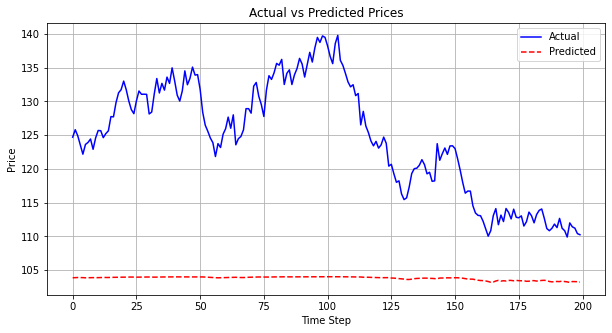

Epoch [51/300] - Combined Loss: 0.5306, MSE: 0.4515, SR: 0.1986, Dir Loss: 0.4942
Epoch [52/300] - Combined Loss: 0.5031, MSE: 0.4263, SR: 0.2079, Dir Loss: 0.4871
Epoch [53/300] - Combined Loss: 0.5273, MSE: 0.4510, SR: 0.2131, Dir Loss: 0.4871
Epoch [54/300] - Combined Loss: 0.5523, MSE: 0.4732, SR: 0.1973, Dir Loss: 0.4936
Epoch [55/300] - Combined Loss: 0.4893, MSE: 0.4110, SR: 0.1916, Dir Loss: 0.4871
Epoch [56/300] - Combined Loss: 0.5107, MSE: 0.4333, SR: 0.2013, Dir Loss: 0.4873
Epoch [57/300] - Combined Loss: 0.5207, MSE: 0.4424, SR: 0.2038, Dir Loss: 0.4930
Epoch [58/300] - Combined Loss: 0.4998, MSE: 0.4220, SR: 0.2088, Dir Loss: 0.4930
Epoch [59/300] - Combined Loss: 0.4934, MSE: 0.4174, SR: 0.2023, Dir Loss: 0.4807
Epoch [60/300] - Combined Loss: 0.5176, MSE: 0.4402, SR: 0.2150, Dir Loss: 0.4938
Epoch [61/300] - Combined Loss: 0.5220, MSE: 0.4462, SR: 0.2035, Dir Loss: 0.4803
Epoch [62/300] - Combined Loss: 0.4794, MSE: 0.4050, SR: 0.2126, Dir Loss: 0.4777
Epoch [63/300] -

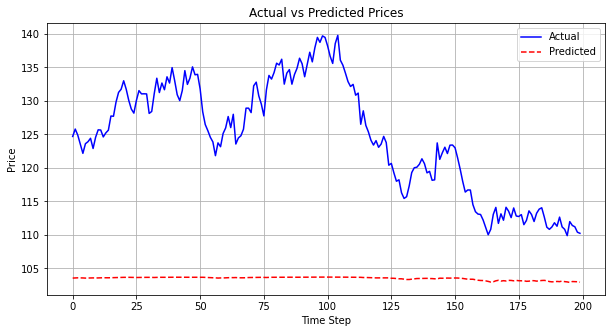

Epoch [101/300] - Combined Loss: 0.5124, MSE: 0.4336, SR: 0.2014, Dir Loss: 0.4944
Epoch [102/300] - Combined Loss: 0.5042, MSE: 0.4272, SR: 0.2031, Dir Loss: 0.4863
Epoch [103/300] - Combined Loss: 0.5142, MSE: 0.4363, SR: 0.1966, Dir Loss: 0.4873
Epoch [104/300] - Combined Loss: 0.5029, MSE: 0.4260, SR: 0.2026, Dir Loss: 0.4853
Epoch [105/300] - Combined Loss: 0.4910, MSE: 0.4135, SR: 0.2024, Dir Loss: 0.4881
Epoch [106/300] - Combined Loss: 0.5165, MSE: 0.4383, SR: 0.2065, Dir Loss: 0.4934
Epoch [107/300] - Combined Loss: 0.4961, MSE: 0.4194, SR: 0.2046, Dir Loss: 0.4853
Epoch [108/300] - Combined Loss: 0.5247, MSE: 0.4448, SR: 0.2042, Dir Loss: 0.5010
Epoch [109/300] - Combined Loss: 0.4807, MSE: 0.4069, SR: 0.2152, Dir Loss: 0.4763
Epoch [110/300] - Combined Loss: 0.5053, MSE: 0.4281, SR: 0.2045, Dir Loss: 0.4877
Epoch [111/300] - Combined Loss: 0.4772, MSE: 0.4037, SR: 0.2092, Dir Loss: 0.4715
Epoch [112/300] - Combined Loss: 0.5082, MSE: 0.4300, SR: 0.2012, Dir Loss: 0.4910
Epoc

KeyboardInterrupt: 

In [5]:
# Training loop with GPU support
model.train()
for epoch in range(1, epochs+1):
    epoch_loss = 0.0
    epoch_mse = 0.0
    epoch_sr = 0.0
    epoch_dir_loss = 0.0
    count = 0

    for features, targets in train_loader:
        # Move features and targets to the GPU
        features = features.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        
        # Predict next-day price
        preds = model(features)
        
        # MSE Loss on prices
        mse_loss = criterion_mse(preds, targets)
        
        # Compute returns
        last_price = features[:, -1, 0]
        predicted_returns = (preds.squeeze() - last_price) / last_price
        actual_returns = (targets.squeeze() - last_price) / last_price
        pnl_return = predicted_returns - actual_returns

        # Compute Sharpe ratio on predicted returns
        sr = sharpe_ratio(pnl_return)
        
        # MSE on returns (if you still want it)
        return_correction_loss = criterion_mse(predicted_returns, actual_returns)
        
        # Directionality loss
        actual_direction = (actual_returns >= 0).float()
        predicted_direction = (predicted_returns >= 0).float()
        direction_loss = criterion_mse(predicted_direction, actual_direction)


        # Combined loss
        loss = mse_loss - lambda_sr * sr + lambda_returns * return_correction_loss + lambda_dir * direction_loss
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_mse += mse_loss.item()
        epoch_sr += sr.item()
        epoch_dir_loss += direction_loss.item()
        count += 1

    avg_loss = epoch_loss / count
    avg_mse = epoch_mse / count
    avg_dir_loss = epoch_dir_loss / count
    avg_sr = epoch_sr / count
    print(f"Epoch [{epoch}/{epochs}] - Combined Loss: {avg_loss:.4f}, MSE: {avg_mse:.4f}, SR: {avg_sr:.4f}, Dir Loss: {avg_dir_loss:.4f}")

    # Every 100 epochs, do a prediction and plot
    if epoch % 50 == 0:
        predict_and_plot(model, test_dataset, N=200)


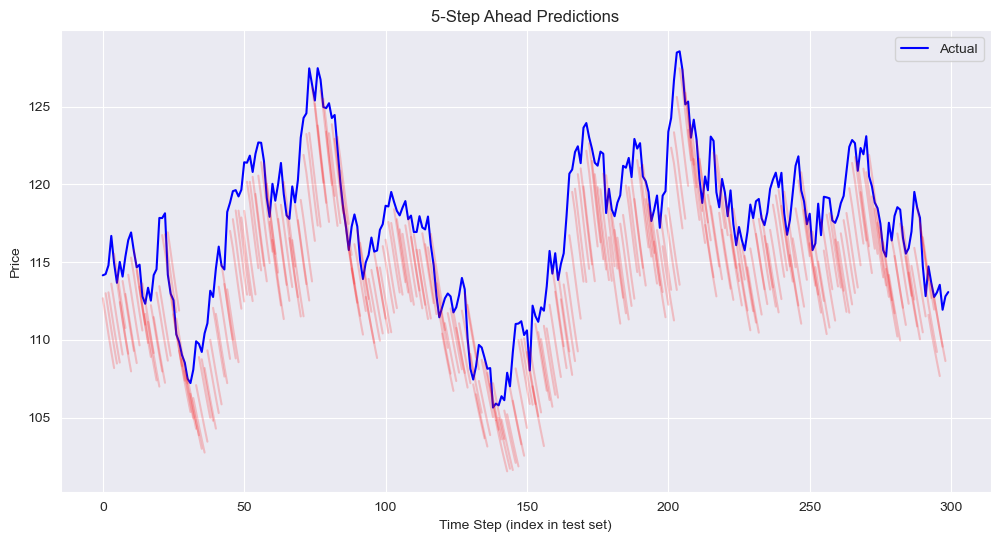

In [27]:
model.eval()

# Parameters for prediction
forecast_horizon = 5  # how many steps ahead to predict
num_samples_to_plot = 20  # how many different sequences to plot

# We'll plot the actual prices for a range of the test dataset
# Let's say we plot the first 300 points of the test dataset's actual prices
N_actual_plot = 300

# Extract actual values from the test dataset for plotting
actual_values = []
for i in range(len(test_dataset)):
    # test_dataset[i] = (features, target)
    # features: (seq_len, 1), target: (1,)
    # The "actual values" here will be the target values aligned after seq_len steps.
    # If we want the full series, we can reconstruct it from the dataset.
    _, y = test_dataset[i]
    actual_values.append(y.item())

# The actual_values are the next-step prices. They start after seq_len from the original data.
# For plotting actual values from index 0 in test_dataset terms, 
# these represent prices at indices [seq_len ... seq_len+(len(test_dataset)-1)] in original scale.
# Just keep it simple and plot them as is. They represent the actual "future" points.

plt.figure(figsize=(12,6))
plt.plot(range(N_actual_plot), actual_values[:N_actual_plot], label='Actual', color='blue')

# Generate multiple forecasts
# We'll pick sequences from different starting points in the test data
# For each starting index, we take the 50-step historical window and predict next 5 steps.
for start_idx in range((N_actual_plot - forecast_horizon)):
    if start_idx >= len(test_dataset):
        break

    # Get the initial features (the last 50 points of a sequence)
    features, _ = test_dataset[start_idx]
    # features: (seq_len, 1)
    current_sequence = features.clone().detach().unsqueeze(0) # (1, seq_len, 1)

    predicted_points = []
    # We have one-step-ahead predictions, so we loop 5 times
    for step in range(forecast_horizon):
        with torch.no_grad():
            pred = model(current_sequence)  # pred: (1,1)
        
        predicted_price = pred.item()
        predicted_points.append(predicted_price)

        # Append this predicted price to the sequence, remove the oldest price
        # Shift the window forward by one step
        new_price_tensor = torch.tensor([[predicted_price]], dtype=torch.float32)
        # current_sequence shape: (1, seq_len, 1)
        current_sequence = torch.cat([current_sequence[:,1:,:], new_price_tensor.unsqueeze(0)], dim=1)

    # Now we have predicted_points: a list of 5 future prices after start_idx
    # The first predicted point corresponds to test_dataset[start_idx] target,
    # which itself is positioned at start_idx in `actual_values`.
    # So predicted_points[0] aligns with actual_values[start_idx],
    # predicted_points[1] aligns with actual_values[start_idx+1], and so forth.
    #
    # We'll plot these predicted points starting at 'start_idx' on the x-axis.
    # The x-axis for predicted points:
    x_range = range(start_idx, start_idx + forecast_horizon)
    plt.plot(x_range, predicted_points, color='red', alpha=0.2)  # low alpha to see multiple paths

plt.title('5-Step Ahead Predictions')
plt.xlabel('Time Step (index in test set)')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# After training your model
torch.save(model.state_dict(), "model_weights.pth")


In [29]:
# # Initialize the same model architecture
# model = TwoLayerLSTM(input_size=1, hidden_size=32, num_layers=2, output_size=1)
# 
# # Load the saved parameters
# model.load_state_dict(torch.load("model_weights.pth"))
# 
# # Set the model to evaluation mode (if you plan to do inference)
# model.eval()


Max Drawdown: 209.0802764892578


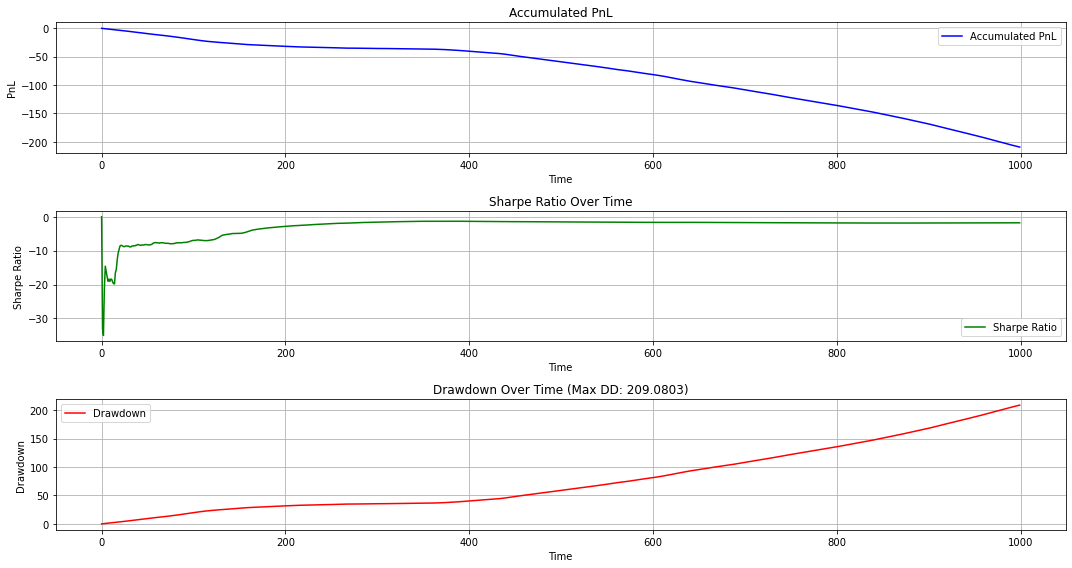

In [3]:
import torch
import matplotlib.pyplot as plt

model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for i in range(len(test_dataset)):
        features, target = test_dataset[i]
        features = features.unsqueeze(0).to(device)  # Move to device
        pred = model(features)
        
        predictions.append(pred.item())
        actuals.append(target.item())

# Convert to tensors for convenience
predictions = torch.tensor(predictions, dtype=torch.float32)
actuals = torch.tensor(actuals, dtype=torch.float32)

# Compute returns
# Need last_price from the input to compute returns.
# Since we have only predictions and actuals, let's reconstruct returns:
# actual_returns = (actual - last_price) / last_price
# predicted_returns = (prediction - last_price) / last_price
#
# However, we need the last_price. We can get it from the test dataset features:
last_prices = []
for i in range(len(test_dataset)):
    features, _ = test_dataset[i]
    # features shape: (seq_len, 1)
    last_price = features[-1,0]  # last price of the input window
    last_prices.append(last_price.item())

last_prices = torch.tensor(last_prices, dtype=torch.float32)

predicted_returns = (predictions - last_prices) / last_prices
actual_returns = (actuals - last_prices) / last_prices

# PnL return = predicted_returns - actual_returns
pnl_returns = predicted_returns - actual_returns

# Accumulated PnL: cumulative sum of pnl_returns
accumulated_pnl = torch.cumsum(pnl_returns, dim=0)

# Compute Sharpe ratio over time:
# Sharpe ratio(t) = mean(pnl_returns[0:t]) / std(pnl_returns[0:t])
sharpe_ratios = []
for t in range(1, len(pnl_returns)+1):
    sub_period = pnl_returns[:t]
    mean_ret = torch.mean(sub_period)
    std_ret = torch.std(sub_period)
    sr = mean_ret / std_ret if std_ret > 1e-12 else torch.tensor(0.0)
    sharpe_ratios.append(sr.item())
sharpe_ratios = torch.tensor(sharpe_ratios)

# Compute drawdown:
# Drawdown = running_max(accumulated_pnl) - accumulated_pnl
# Maximum drawdown is the max of this drawdown series
running_max = torch.cummax(accumulated_pnl, dim=0)[0]
drawdown = running_max - accumulated_pnl
max_drawdown = torch.max(drawdown).item()

print("Max Drawdown:", max_drawdown)

# Plotting
plt.figure(figsize=(15, 8))

plt.subplot(3,1,1)
plt.plot(accumulated_pnl.cpu().numpy(), label='Accumulated PnL', color='blue')
plt.title('Accumulated PnL')
plt.xlabel('Time')
plt.ylabel('PnL')
plt.grid(True)
plt.legend()

plt.subplot(3,1,2)
plt.plot(sharpe_ratios.cpu().numpy(), label='Sharpe Ratio', color='green')
plt.title('Sharpe Ratio Over Time')
plt.xlabel('Time')
plt.ylabel('Sharpe Ratio')
plt.grid(True)
plt.legend()

plt.subplot(3,1,3)
plt.plot(drawdown.cpu().numpy(), label='Drawdown', color='red')
plt.title('Drawdown Over Time (Max DD: {:.4f})'.format(max_drawdown))
plt.xlabel('Time')
plt.ylabel('Drawdown')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
